In [5]:
%load_ext autoreload
%autoreload 2
from pyhealth.datasets import MIMIC3Dataset


root = '/data/qf31/FBen/mimic-iii-clinical-database-1.4'
mimic3base = MIMIC3Dataset(
    root=root,
    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"], # PRESCRIPTIONS
    # map all NDC codes to ATC 3-rd level codes in these tables
    code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 3}})},
    dev=True,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from pyhealth.data import Patient, Visit
def drug_recommendation_mimic3_fn(patient: Patient):
    """Processes a single patient for the drug recommendation task.

    Drug recommendation aims at recommending a set of drugs given the patient health
    history  (e.g., conditions and procedures).

    Args:
        patient: a Patient object

    Returns:
        samples: a list of samples, each sample is a dict with patient_id, visit_id,
            and other task-specific attributes as key

    Examples:
        >>> from pyhealth.datasets import MIMIC3Dataset
        >>> mimic3_base = MIMIC3Dataset(
        ...    root="/srv/local/data/physionet.org/files/mimiciii/1.4",
        ...    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
        ...    code_mapping={"ICD9CM": "CCSCM"},
        ... )
        >>> from pyhealth.tasks import drug_recommendation_mimic3_fn
        >>> mimic3_sample = mimic3_base.set_task(drug_recommendation_mimic3_fn)
        >>> mimic3_sample.samples[0]
        [{'visit_id': '130744', 'patient_id': '103', 'conditions': [['42', '109', '19', '122', '98', '663', '58', '51']], 'procedures': [['1']], 'label': [['2', '3', '4']]}]
    """
    samples = []
    for i in range(len(patient)):
        visit: Visit = patient[i]
        conditions = visit.get_code_list(table="DIAGNOSES_ICD")
        procedures = visit.get_code_list(table="PROCEDURES_ICD")
        drugs = visit.get_code_list(table="PRESCRIPTIONS")
        # ATC 3 level
        drugs = [drug[:4] for drug in drugs]
        # exclude: visits without condition, procedure, or drug code
        if len(conditions) * len(procedures) * len(drugs) == 0:
            continue
        # TODO: should also exclude visit with age < 18
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "conditions": conditions,
                "procedures": procedures,
                "drugs": drugs,
                "drugs_all": drugs,
                "patient_gender": patient.gender,
            }
        )
    # exclude: patients with less than 2 visit
    if len(samples) < 2:
        return []
    # add history
    samples[0]["conditions"] = [samples[0]["conditions"]]
    samples[0]["procedures"] = [samples[0]["procedures"]]
    samples[0]["drugs_all"] = [samples[0]["drugs_all"]]

    for i in range(1, len(samples)):
        samples[i]["conditions"] = samples[i - 1]["conditions"] + [
            samples[i]["conditions"]
        ]
        samples[i]["procedures"] = samples[i - 1]["procedures"] + [
            samples[i]["procedures"]
        ]
        samples[i]["drugs_all"] = samples[i - 1]["drugs_all"] + [
            samples[i]["drugs_all"]
        ]

    return samples

In [7]:
import math
from typing import List, Optional, Tuple, Dict

import torch
from torch import nn

from pyhealth.datasets import SampleDataset
from pyhealth.models import BaseModel
from pyhealth.tokenizer import Tokenizer
from pyhealth.models import TransformerLayer

class Adv_Transformer(BaseModel):
    """Transformer model.

    This model applies a separate Transformer layer for each feature, and then
    concatenates the final hidden states of each Transformer layer. The concatenated
    hidden states are then fed into a fully connected layer to make predictions.

    Note:
        We use separate Transformer layers for different feature_keys.
        Currentluy, we automatically support different input formats:
            - code based input (need to use the embedding table later)
            - float/int based value input
        We follow the current convention for the transformer model:
            - case 1. [code1, code2, code3, ...]
                - we will assume the code follows the order; our model will encode
                each code into a vector and apply transformer on the code level
            - case 2. [[code1, code2]] or [[code1, code2], [code3, code4, code5], ...]
                - we will assume the inner bracket follows the order; our model first
                use the embedding table to encode each code into a vector and then use
                average/mean pooling to get one vector for one inner bracket; then use
                transformer one the braket level
            - case 3. [[1.5, 2.0, 0.0]] or [[1.5, 2.0, 0.0], [8, 1.2, 4.5], ...]
                - this case only makes sense when each inner bracket has the same length;
                we assume each dimension has the same meaning; we run transformer directly
                on the inner bracket level, similar to case 1 after embedding table
            - case 4. [[[1.5, 2.0, 0.0]]] or [[[1.5, 2.0, 0.0], [8, 1.2, 4.5]], ...]
                - this case only makes sense when each inner bracket has the same length;
                we assume each dimension has the same meaning; we run transformer directly
                on the inner bracket level, similar to case 2 after embedding table

        dataset: the dataset to train the model. It is used to query certain
            information such as the set of all tokens.
        feature_keys:  list of keys in samples to use as features,
            e.g. ["conditions", "procedures"].
        label_key: key in samples to use as label (e.g., "drugs").
        mode: one of "binary", "multiclass", or "multilabel".
        embedding_dim: the embedding dimension. Default is 128.
        **kwargs: other parameters for the Transformer layer.

    Examples:
        >>> from pyhealth.datasets import SampleDataset
        >>> samples = [
        ...         {
        ...             "patient_id": "patient-0",
        ...             "visit_id": "visit-0",
        ...             "list_codes": ["505800458", "50580045810", "50580045811"],  # NDC
        ...             "list_vectors": [[1.0, 2.55, 3.4], [4.1, 5.5, 6.0]],
        ...             "list_list_codes": [["A05B", "A05C", "A06A"], ["A11D", "A11E"]],  # ATC-4
        ...             "list_list_vectors": [
        ...                 [[1.8, 2.25, 3.41], [4.50, 5.9, 6.0]],
        ...                 [[7.7, 8.5, 9.4]],
        ...             ],
        ...             "label": 1,
        ...         },
        ...         {
        ...             "patient_id": "patient-0",
        ...             "visit_id": "visit-1",
        ...             "list_codes": [
        ...                 "55154191800",
        ...                 "551541928",
        ...                 "55154192800",
        ...                 "705182798",
        ...                 "70518279800",
        ...             ],
        ...             "list_vectors": [[1.4, 3.2, 3.5], [4.1, 5.9, 1.7], [4.5, 5.9, 1.7]],
        ...             "list_list_codes": [["A04A", "B035", "C129"]],
        ...             "list_list_vectors": [
        ...                 [[1.0, 2.8, 3.3], [4.9, 5.0, 6.6], [7.7, 8.4, 1.3], [7.7, 8.4, 1.3]],
        ...             ],
        ...             "label": 0,
        ...         },
        ...     ]
        >>> dataset = SampleDataset(samples=samples, dataset_name="test")
        >>>
        >>> from pyhealth.models import Transformer
        >>> model = Transformer(
        ...         dataset=dataset,
        ...         feature_keys=[
        ...             "list_codes",
        ...             "list_vectors",
        ...             "list_list_codes",
        ...             "list_list_vectors",
        ...         ],
        ...         label_key="label",
        ...         mode="binary",
        ...     )
        >>>
        >>> from pyhealth.datasets import get_dataloader
        >>> train_loader = get_dataloader(dataset, batch_size=2, shuffle=True)
        >>> data_batch = next(iter(train_loader))
        >>>
        >>> ret = model(**data_batch)
        >>> print(ret)
        {'loss': tensor(0.4234, grad_fn=<NllLossBackward0>), 'y_prob': tensor([[9.9998e-01, 2.2920e-05],
                [5.7120e-01, 4.2880e-01]], grad_fn=<SoftmaxBackward0>), 'y_true': tensor([0, 1])}
        >>>

    """

    def __init__(
        self,
        dataset: SampleDataset,
        feature_keys: List[str],
        label_key: str,
        sens_key: str,
        mode: str,
        sens_mode: str,
        embedding_dim: int = 128,
        **kwargs
    ):
        super(Adv_Transformer, self).__init__(
            dataset=dataset,
            feature_keys=feature_keys,
            label_key=label_key,
            mode=mode,
        )

        self.sens_mode = sens_mode
        self.embedding_dim = embedding_dim

        # /**------ store sens key ------**/
        self.sens_key = sens_key
        # /**------ store sens key ------**/

        # validate kwargs for Transformer layer
        if "feature_size" in kwargs:
            raise ValueError("feature_size is determined by embedding_dim")

        # the key of self.feat_tokenizers only contains the code based inputs
        self.feat_tokenizers = {}
        self.label_tokenizer = self.get_label_tokenizer()

        # /**------ prepare sens tokenizer ------**/
        self.sens_tokenizer = self.get_sens_tokenizer()
        # /**------ prepare sens tokenizer ------**/


        # the key of self.embeddings only contains the code based inputs
        self.embeddings = nn.ModuleDict()
        # the key of self.linear_layers only contains the float/int based inputs
        self.linear_layers = nn.ModuleDict()

        # add feature transformation layers
        for feature_key in self.feature_keys:
            input_info = self.dataset.input_info[feature_key]
            # sanity check
            if input_info["type"] not in [str, float, int]:
                raise ValueError(
                    "Transformer only supports str code, float and int as input types"
                )
            elif (input_info["type"] == str) and (input_info["dim"] not in [2, 3]):
                raise ValueError(
                    "Transformer only supports 2-dim or 3-dim str code as input types"
                )
            elif (input_info["type"] in [float, int]) and (
                input_info["dim"] not in [2, 3]
            ):
                raise ValueError(
                    "Transformer only supports 2-dim or 3-dim float and int as input types"
                )
            # for code based input, we need Type
            # for float/int based input, we need Type, input_dim
            self.add_feature_transform_layer(feature_key, input_info)

        self.transformer = nn.ModuleDict()
        for feature_key in feature_keys:
            self.transformer[feature_key] = TransformerLayer(
                feature_size=embedding_dim, **kwargs
            )
        output_size = self.get_output_size(self.label_tokenizer)
        # transformer's output feature size is still embedding_dim
        self.fc = nn.Linear(len(self.feature_keys) * self.embedding_dim, output_size)

        #self.sens_fc = nn.Linear(len(self.feature_keys) * self.embedding_dim, self.get_output_size(self.sens_tokenizer))
        self.sens_fc = nn.Sequential(
            nn.Linear(len(self.feature_keys) * self.embedding_dim, len(self.feature_keys) * self.embedding_dim),
            nn.ReLU(),
            nn.Linear(len(self.feature_keys) * self.embedding_dim, self.get_output_size(self.sens_tokenizer)),
        )

    def forward(self, **kwargs) -> Dict[str, torch.Tensor]:
        """Forward propagation.

        The label `kwargs[self.label_key]` is a list of labels for each patient.

        Args:
            **kwargs: keyword arguments for the model. The keys must contain
                all the feature keys and the label key.

        Returns:
            A dictionary with the following keys:
                loss: a scalar tensor representing the loss.
                y_prob: a tensor representing the predicted probabilities.
                y_true: a tensor representing the true labels.
        """
        patient_emb = []
        for feature_key in self.feature_keys:
            input_info = self.dataset.input_info[feature_key]
            dim_, type_ = input_info["dim"], input_info["type"]

            # for case 1: [code1, code2, code3, ...]
            if (dim_ == 2) and (type_ == str):
                x = self.feat_tokenizers[feature_key].batch_encode_2d(
                    kwargs[feature_key]
                )
                # (patient, event)
                x = torch.tensor(x, dtype=torch.long, device=self.device)
                # (patient, event, embedding_dim)
                x = self.embeddings[feature_key](x)
                # (patient, event)
                mask = torch.sum(x, dim=2) != 0

            # for case 2: [[code1, code2], [code3, ...], ...]
            elif (dim_ == 3) and (type_ == str):
                x = self.feat_tokenizers[feature_key].batch_encode_3d(
                    kwargs[feature_key]
                )
                # (patient, visit, event)
                x = torch.tensor(x, dtype=torch.long, device=self.device)
                # (patient, visit, event, embedding_dim)
                x = self.embeddings[feature_key](x)
                # (patient, visit, embedding_dim)
                x = torch.sum(x, dim=2)
                # (patient, visit)
                mask = torch.sum(x, dim=2) != 0

            # for case 3: [[1.5, 2.0, 0.0], ...]
            elif (dim_ == 2) and (type_ in [float, int]):
                x, mask = self.padding2d(kwargs[feature_key])
                # (patient, event, values)
                x = torch.tensor(x, dtype=torch.float, device=self.device)
                # (patient, event, embedding_dim)
                x = self.linear_layers[feature_key](x)
                # (patient, event)
                mask = mask.bool().to(self.device)

            # for case 4: [[[1.5, 2.0, 0.0], [1.8, 2.4, 6.0]], ...]
            elif (dim_ == 3) and (type_ in [float, int]):
                x, mask = self.padding3d(kwargs[feature_key])
                # (patient, visit, event, values)
                x = torch.tensor(x, dtype=torch.float, device=self.device)
                # (patient, visit, embedding_dim)
                x = torch.sum(x, dim=2)
                x = self.linear_layers[feature_key](x)
                mask = mask[:, :, 0]
                mask = mask.bool().to(self.device)

            else:
                raise NotImplementedError

            _, x = self.transformer[feature_key](x, mask)
            patient_emb.append(x)

        patient_emb = torch.cat(patient_emb, dim=1)
        # (patient, label_size)
        logits = self.fc(patient_emb)
        sens_logits = self.sens_fc(patient_emb)
        # obtain y_true, loss, y_prob
        y_true = self.prepare_labels(kwargs[self.label_key], self.label_tokenizer)
        sens_true = self.prepare_sens_labels(kwargs[self.sens_key], self.sens_tokenizer)
        loss = self.get_loss_function()(logits, y_true)
        #print('sens_true.shape', sens_true)
        sens_loss = self.get_sens_loss_function()(sens_logits, sens_true)
        y_prob = self.prepare_y_prob(logits)
        return {
            "loss": loss,
            "sens_loss": sens_loss,
            "y_prob": y_prob,
            "y_true": y_true,
            "sens_true": sens_true,
            "patient_emb": patient_emb,
        }

    def get_sens_tokenizer(self, special_tokens=None) -> Tokenizer:
        """Gets the default sens tokenizers using `self.sens_key`.

        Args:
            special_tokens: a list of special tokens to add to the tokenizer.
                Default is empty list.

        Returns:
            sens_tokenizer: the sens tokenizer.
        """
        if special_tokens is None:
            special_tokens = []
        sens_tokenizer = Tokenizer(
            self.dataset.get_all_tokens(key=self.sens_key),
            special_tokens=special_tokens,
        )
        return sens_tokenizer

In [8]:
from pyhealth.trainer import *
class Adv_Trainer:
    """Trainer for PyTorch models.

    Args:
        model: PyTorch model.
        checkpoint_path: Path to the checkpoint. Default is None, which means
            the model will be randomly initialized.
        metrics: List of metric names to be calculated. Default is None, which
            means the default metrics in each metrics_fn will be used.
        device: Device to be used for training. Default is None, which means
            the device will be GPU if available, otherwise CPU.
        enable_logging: Whether to enable logging. Default is True.
        output_path: Path to save the output. Default is "./output".
        exp_name: Name of the experiment. Default is current datetime.
    """

    def __init__(
        self,
        model: nn.Module,
        checkpoint_path: Optional[str] = None,
        metrics: Optional[List[str]] = None,
        device: Optional[str] = None,
        enable_logging: bool = True,
        output_path: Optional[str] = None,
        exp_name: Optional[str] = None,
    ):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"

        self.model = model
        self.metrics = metrics
        self.device = device


        # set logger
        if enable_logging:
            if output_path is None:
                output_path = os.path.join(os.getcwd(), "output")
            if exp_name is None:
                exp_name = datetime.now().strftime("%Y%m%d-%H%M%S")
            self.exp_path = os.path.join(output_path, exp_name)
            set_logger(self.exp_path)
        else:
            self.exp_path = None

        # set device
        self.model.to(self.device)

        # logging
        logger.info(self.model)
        logger.info(f"Metrics: {self.metrics}")
        logger.info(f"Device: {self.device}")

        # load checkpoint
        if checkpoint_path is not None:
            logger.info(f"Loading checkpoint from {checkpoint_path}")
            self.load_ckpt(checkpoint_path)

        logger.info("")
        return


    def train(
        self,
        train_dataloader: DataLoader,
        val_dataloader: Optional[DataLoader] = None,
        test_dataloader: Optional[DataLoader] = None,
        epochs: int = 5,
        optimizer_class: Type[Optimizer] = torch.optim.Adam,
        optimizer_params: Optional[Dict[str, object]] = None,
        weight_decay: float = 0.0,
        max_grad_norm: float = None,
        monitor: Optional[str] = None,
        monitor_criterion: str = "max",
        load_best_model_at_last: bool = True,
        **kwargs,
    ):
        """Trains the model.

        Args:
            train_dataloader: Dataloader for training.
            val_dataloader: Dataloader for validation. Default is None.
            test_dataloader: Dataloader for testing. Default is None.
            epochs: Number of epochs. Default is 5.
            optimizer_class: Optimizer class. Default is torch.optim.Adam.
            optimizer_params: Parameters for the optimizer. Default is {"lr": 1e-3}.
            weight_decay: Weight decay. Default is 0.0.
            max_grad_norm: Maximum gradient norm. Default is None.
            monitor: Metric name to monitor. Default is None.
            monitor_criterion: Criterion to monitor. Default is "max".
            load_best_model_at_last: Whether to load the best model at the last.
                Default is True.
        """
        if optimizer_params is None:
            optimizer_params = {"lr": 1e-3}

        # logging
        logger.info("Training:")
        logger.info(f"Batch size: {train_dataloader.batch_size}")
        logger.info(f"Optimizer: {optimizer_class}")
        logger.info(f"Optimizer params: {optimizer_params}")
        logger.info(f"Weight decay: {weight_decay}")
        logger.info(f"Max grad norm: {max_grad_norm}")
        logger.info(f"Val dataloader: {val_dataloader}")
        logger.info(f"Monitor: {monitor}")
        logger.info(f"Monitor criterion: {monitor_criterion}")
        logger.info(f"Epochs: {epochs}")

        # set optimizer
        param = list(self.model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in param if not any(nd in n for nd in no_decay)],
                "weight_decay": weight_decay,
            },
            {
                "params": [p for n, p in param if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optimizer_class(optimizer_grouped_parameters, **optimizer_params)

        adv_optimizer = optimizer_class(list(self.model.sens_fc.parameters()), **optimizer_params) # only contains adv_cls param

        # initialize
        data_iterator = iter(train_dataloader)
        best_score = -1 * float("inf") if monitor_criterion == "max" else float("inf")
        steps_per_epoch = len(train_dataloader)
        global_step = 0

        # epoch training loop
        for epoch in range(epochs):
            training_loss = []
            sens_loss_list = []
            self.model.zero_grad()
            self.model.train()
            # batch training loop
            logger.info("")
            for _ in trange(
                steps_per_epoch,
                desc=f"Epoch {epoch} / {epochs}",
                smoothing=0.05,
            ):
                try:
                    data = next(data_iterator)
                except StopIteration:
                    data_iterator = iter(train_dataloader)
                    data = next(data_iterator)
                
                # /**------- update backbone and cls -------**/
                # freeze sens_fc
                self.model.sens_fc.requires_grad_(False)

                # forward
                output = self.model(**data)
                loss = output["loss"]
                sens_loss = output['sens_loss']
                
                adv_rate = kwargs['adv_rate'] if 'adv_rate' in kwargs.keys() else 0.0
                total_loss = loss - adv_rate * sens_loss # make sens_cls bad

                # backward
                total_loss.backward()
                if max_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(
                        self.model.parameters(), max_grad_norm
                    )
                # update
                #print('/**------ sens_fc before optimizer step ------**/')
                #print(list(model.sens_fc.named_parameters()))
                optimizer.step()
                optimizer.zero_grad()
                training_loss.append(loss.item())
                
                # /**------- update sens_cls -------**/
                # grad sens_fc
                self.model.sens_fc.requires_grad_(True)
                # forward
                output = self.model(**data)
                loss = output["loss"]
                sens_loss = output['sens_loss']

                sens_loss.backward()
                adv_optimizer.step()
                adv_optimizer.zero_grad()
                sens_loss_list.append(sens_loss.item())

                global_step += 1
            # log and save
            logger.info(f"--- Train epoch-{epoch}, step-{global_step} ---")
            logger.info(f"loss: {sum(training_loss) / len(training_loss):.4f}, sens_loss: {sum(sens_loss_list) / len(sens_loss_list):.4f}")
            if self.exp_path is not None:
                self.save_ckpt(os.path.join(self.exp_path, "last.ckpt"))

            # validation
            if val_dataloader is not None:
                scores = self.evaluate(val_dataloader)
                logger.info(f"--- Eval epoch-{epoch}, step-{global_step} ---")
                for key in scores.keys():
                    logger.info("{}: {:.4f}".format(key, scores[key]))
                # save best model
                if monitor is not None:
                    score = scores[monitor]
                    if is_best(best_score, score, monitor_criterion):
                        logger.info(
                            f"New best {monitor} score ({score:.4f}) "
                            f"at epoch-{epoch}, step-{global_step}"
                        )
                        best_score = score
                        if self.exp_path is not None:
                            self.save_ckpt(os.path.join(self.exp_path, "best.ckpt"))

        # load best model
        if load_best_model_at_last and self.exp_path is not None:
            logger.info("Loaded best model")
            self.load_ckpt(os.path.join(self.exp_path, "best.ckpt"))

        # test
        if test_dataloader is not None:
            scores = self.evaluate(test_dataloader)
            logger.info(f"--- Test ---")
            for key in scores.keys():
                logger.info("{}: {:.4f}".format(key, scores[key]))

        return

    def inference(self, dataloader) -> Dict[str, float]:
        """Model inference.

        Args:
            dataloader: Dataloader for evaluation.

        Returns:
            y_true_all: List of true labels.
            y_prob_all: List of predicted probabilities.
            loss_mean: Mean loss over batches.
        """
        loss_all = []
        y_true_all = []
        y_prob_all = []
        for data in tqdm(dataloader, desc="Evaluation"):
            self.model.eval()
            with torch.no_grad():
                output = self.model(**data)
                loss = output["loss"]
                y_true = output["y_true"].cpu().numpy()
                y_prob = output["y_prob"].cpu().numpy()
                loss_all.append(loss.item())
                y_true_all.append(y_true)
                y_prob_all.append(y_prob)
        loss_mean = sum(loss_all) / len(loss_all)
        y_true_all = np.concatenate(y_true_all, axis=0)
        y_prob_all = np.concatenate(y_prob_all, axis=0)
        return y_true_all, y_prob_all, loss_mean

    def evaluate(self, dataloader) -> Dict[str, float]:
        """Evaluates the model.

        Args:
            dataloader: Dataloader for evaluation.

        Returns:
            scores: a dictionary of scores.
        """
        y_true_all, y_prob_all, loss_mean = self.inference(dataloader)

        mode = self.model.mode
        metrics_fn = get_metrics_fn(mode)
        scores = metrics_fn(y_true_all, y_prob_all, metrics=self.metrics)
        scores["loss"] = loss_mean
        return scores

    def fair_check(self, dataloader) -> Dict[str, float]:
        """Evaluates fairness metric for the model.

        Args:
            dataloader: Dataloader for evaluation.

        Returns:
            scores: a dictionary of scores.
        """
        loss_all = []
        y_true_all = []
        y_prob_all = []
        sens_true_all = []
        for data in tqdm(dataloader, desc="Evaluation"):
            self.model.eval()
            with torch.no_grad():
                output = self.model(**data)
                loss = output["loss"]
                y_true = output["y_true"].cpu().numpy()
                y_prob = output["y_prob"].cpu().numpy()
                sens_true = output["sens_true"].cpu().numpy()
                loss_all.append(loss.item())
                y_true_all.append(y_true)
                y_prob_all.append(y_prob)
                sens_true_all.append(sens_true)
        loss_mean = sum(loss_all) / len(loss_all)
        y_true_all = np.concatenate(y_true_all, axis=0)
        y_prob_all = np.concatenate(y_prob_all, axis=0)
        sens_true_all = np.concatenate(sens_true_all, axis=0)

        # return y_true_all, y_prob_all, sens_true_all, loss_mean
        # calculate fairness metric, depend on mode (task) and sens_mode (sens)
        # only support binary sens now


        mode = self.model.mode
        metrics_fn = get_metrics_fn(mode)

        # get score for different group
        def get_scores(idx):
            scores = metrics_fn(y_true_all[idx], y_prob_all[idx], metrics=self.metrics)
            return scores

        scores_0 = get_scores(sens_true_all==0)
        scores_1 = get_scores(sens_true_all==1)

        fair_scores = {}
        print
        for metric in scores_0.keys():
            fair_scores[metric] = np.abs(scores_0[metric] - scores_1[metric])
        return fair_scores
        
    def save_ckpt(self, ckpt_path: str) -> None:
        """Saves the model checkpoint."""
        state_dict = self.model.state_dict()
        torch.save(state_dict, ckpt_path)
        return

    def load_ckpt(self, ckpt_path: str) -> None:
        """Saves the model checkpoint."""
        state_dict = torch.load(ckpt_path, map_location=self.device)
        self.model.load_state_dict(state_dict)
        return

In [9]:
from itertools import chain
from typing import Optional, Tuple, Union, List

import numpy as np
import torch

from pyhealth.datasets import SampleDataset

def split_by_patient(
    dataset: SampleDataset,
    ratios: Union[Tuple[float, float, float], List[float]],
    seed: Optional[int] = None,
):
    """Splits the dataset by patient.

    Args:
        dataset: a `SampleDataset` object
        ratios: a list/tuple of ratios for train / val / test
        seed: random seed for shuffling the dataset

    Returns:
        train_dataset, val_dataset, test_dataset: three subsets of the dataset of
            type `torch.utils.data.Subset`.

    Note:
        The original dataset can be accessed by `train_dataset.dataset`,
            `val_dataset.dataset`, and `test_dataset.dataset`.
    """
    if seed is not None:
        np.random.seed(seed)
    assert sum(ratios) == 1.0, "ratios must sum to 1.0"
    patient_indx = list(dataset.patient_to_index.keys())
    num_patients = len(patient_indx)
    np.random.shuffle(patient_indx)
    train_patient_indx = patient_indx[: int(num_patients * ratios[0])]
    val_patient_indx = patient_indx[
        int(num_patients * ratios[0]) : int(num_patients * (ratios[0] + ratios[1]))
    ]
    test_patient_indx = patient_indx[int(num_patients * (ratios[0] + ratios[1])) :]
    train_index = list(
        chain(*[dataset.patient_to_index[i] for i in train_patient_indx])
    )
    val_index = list(chain(*[dataset.patient_to_index[i] for i in val_patient_indx]))
    test_index = list(chain(*[dataset.patient_to_index[i] for i in test_patient_indx]))
    train_dataset = torch.utils.data.Subset(dataset, train_index)
    val_dataset = torch.utils.data.Subset(dataset, val_index)
    test_dataset = torch.utils.data.Subset(dataset, test_index)
    return train_dataset, val_dataset, test_dataset,


In [14]:
#from pyhealth.tasks import drug_recommendation_mimic3_fn, mortality_prediction_mimic3_fn, readmission_prediction_mimic3_fn
from pyhealth.datasets import split_by_patient, get_dataloader

mimic3sample = mimic3base.set_task(task_fn=drug_recommendation_mimic3_fn) # use default task
train_ds, val_ds, test_ds = split_by_patient(mimic3sample, [0.8, 0.1, 0.1])
#train_ds, val_ds, test_ds = split_by_patient(mimic3sample, [1.0, 0.0, 0.0])

# create dataloaders (torch.data.DataLoader)
train_loader = get_dataloader(train_ds, batch_size=32, shuffle=True)
val_loader = get_dataloader(val_ds, batch_size=32, shuffle=False)
test_loader = get_dataloader(test_ds, batch_size=32, shuffle=False)

Generating samples for drug_recommendation_mimic3_fn: 100%|██████████| 1000/1000 [00:00<00:00, 24940.56it/s]


In [15]:
def subsample_subdataset(ds):
    sens_list = []
    for idx in ds.indices:
        #print(train_ds.dataset[idx])
        sens_list += [ds.dataset[idx]['patient_gender']]
        #break  
    sens_list = np.array(sens_list)

    # statistic inform extract
    sens_num_dict = {}
    for sens_ in set(sens_list):
        sens_num_dict[sens_] = np.sum(sens_list == sens_)
    min_num = min(sens_num_dict.values())

    # balance indices
    balance_indices = []
    for sens_ in set(sens_list):
        # find indices for sens_ group
        sens_idx = np.where(sens_list == sens_)[0]
        if len(sens_idx) == min_num:
            # minority class do not need sub sample
            balance_indices += [sens_idx]
        else:
            sub_sample_idx = np.random.choice(sens_idx, min_num, replace=False)
            balance_indices += [sub_sample_idx]
            #print(sens_, sub_sample_idx)
    balance_indices = np.concatenate(balance_indices)
    balance_indices = list((np.array(train_ds.indices)[balance_indices]))
    ds.indices = balance_indices
    return ds

In [13]:
train_ds = subsample_subdataset(train_ds)
train_loader = get_dataloader(train_ds, batch_size=32, shuffle=True)

In [6]:
mimic3sample.__dict__.keys()

dict_keys(['samples', 'dataset_name', 'task_name', 'input_info', 'patient_to_index', 'visit_to_index'])

In [7]:
mimic3sample.samples[0].keys()

dict_keys(['visit_id', 'patient_id', 'conditions', 'procedures', 'drugs', 'drugs_all', 'patient_gender'])

In [8]:
mimic3sample.samples[0]['drugs']

['A02B',
 'B05X',
 'C01D',
 'A06A',
 'N01A',
 'N05C',
 'H02A',
 'B01A',
 'B03X',
 'N02A',
 'H05B',
 'D06A',
 'V03A',
 'C07A',
 'B03B',
 'G01A',
 'C10A',
 'B03A',
 'N02B',
 'B05B',
 'C05B',
 'A07X',
 'N06A',
 'J01E']

In [24]:
model = Adv_Transformer(
    dataset=mimic3sample,# the dataset should provide sens feat
    feature_keys=["conditions", "procedures"], # the model should specify the sens feat
    label_key="drugs",
    sens_key='patient_gender',
    mode="multilabel",
    sens_mode = 'multiclass',
    # the model should provide sensitive attribute
)

In [26]:
from pyhealth.trainer import Trainer

trainer = Adv_Trainer(model=model,device='cuda:0')

#trainer = Trainer(model=model,device='cuda:0')
trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=100,
    monitor="pr_auc_samples",
    adv_rate = 10.0,
)

Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=1

Epoch 0 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

/**------ sens_fc before optimizer step ------**/
[('0.weight', Parameter containing:
tensor([[ 0.0636,  0.0039, -0.0130,  ...,  0.0256,  0.0145,  0.0543],
        [ 0.0187,  0.0457, -0.0124,  ..., -0.0024, -0.0131, -0.0135],
        [-0.0193, -0.0008, -0.0418,  ..., -0.0345,  0.0455, -0.0010],
        ...,
        [ 0.0487,  0.0164, -0.0006,  ..., -0.0216, -0.0333, -0.0249],
        [ 0.0541,  0.0546,  0.0415,  ...,  0.0082,  0.0553,  0.0610],
        [ 0.0453, -0.0374, -0.0518,  ...,  0.0267,  0.0030,  0.0647]],
       device='cuda:0')), ('0.bias', Parameter containing:
tensor([ 0.0256,  0.0442,  0.0088, -0.0539,  0.0497,  0.0134,  0.0016,  0.0216,
        -0.0551,  0.0140, -0.0474,  0.0490,  0.0302,  0.0497,  0.0574,  0.0574,
        -0.0262, -0.0289,  0.0304,  0.0592,  0.0155, -0.0359, -0.0034,  0.0352,
        -0.0094,  0.0645,  0.0382,  0.0412,  0.0583,  0.0023,  0.0477, -0.0097,
         0.0634,  0.0076,  0.0332,  0.0416,  0.0487, -0.0234,  0.0369,  0.0199,
        -0.0282,  0.0

--- Train epoch-0, step-9 ---
loss: 0.6250, sens_loss: 0.4847
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 175.05it/s]
--- Eval epoch-0, step-9 ---
pr_auc_samples: 0.5031
loss: 0.4881
New best pr_auc_samples score (0.5031) at epoch-0, step-9



[('0.weight', Parameter containing:
tensor([[ 0.0652,  0.0047, -0.0091,  ...,  0.0323,  0.0168,  0.0517],
        [ 0.0202,  0.0482, -0.0149,  ..., -0.0073, -0.0162, -0.0111],
        [-0.0244,  0.0053, -0.0485,  ..., -0.0300,  0.0412, -0.0054],
        ...,
        [ 0.0485,  0.0171, -0.0006,  ..., -0.0166, -0.0355, -0.0296],
        [ 0.0591,  0.0553,  0.0411,  ...,  0.0098,  0.0558,  0.0599],
        [ 0.0391, -0.0308, -0.0552,  ...,  0.0268, -0.0034,  0.0673]],
       device='cuda:0', requires_grad=True)), ('0.bias', Parameter containing:
tensor([ 2.2877e-02,  4.8443e-02,  9.6761e-03, -5.1093e-02,  5.0640e-02,
         1.4177e-02,  4.3402e-03,  2.0996e-02, -5.8496e-02,  1.1937e-02,
        -4.9687e-02,  4.6775e-02,  3.2319e-02,  4.6640e-02,  5.9596e-02,
         5.4203e-02, -2.7645e-02, -2.7907e-02,  3.0317e-02,  6.1005e-02,
         1.5262e-02, -3.4348e-02, -6.1477e-04,  3.3555e-02, -1.1870e-02,
         6.2528e-02,  3.4434e-02,  4.3949e-02,  5.5503e-02,  3.8737e-05,
         4.63

Epoch 1 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

/**------ sens_fc before optimizer step ------**/
[('0.weight', Parameter containing:
tensor([[ 0.0654,  0.0050, -0.0086,  ...,  0.0328,  0.0170,  0.0518],
        [ 0.0205,  0.0483, -0.0152,  ..., -0.0076, -0.0159, -0.0111],
        [-0.0247,  0.0056, -0.0490,  ..., -0.0295,  0.0409, -0.0054],
        ...,
        [ 0.0485,  0.0170, -0.0009,  ..., -0.0160, -0.0360, -0.0292],
        [ 0.0596,  0.0557,  0.0410,  ...,  0.0100,  0.0559,  0.0602],
        [ 0.0386, -0.0307, -0.0554,  ...,  0.0267, -0.0039,  0.0673]],
       device='cuda:0')), ('0.bias', Parameter containing:
tensor([ 0.0229,  0.0484,  0.0100, -0.0516,  0.0508,  0.0147,  0.0046,  0.0211,
        -0.0592,  0.0118, -0.0502,  0.0473,  0.0328,  0.0468,  0.0596,  0.0547,
        -0.0280, -0.0285,  0.0310,  0.0607,  0.0156, -0.0341, -0.0007,  0.0331,
        -0.0125,  0.0628,  0.0342,  0.0439,  0.0555,  0.0002,  0.0458, -0.0118,
         0.0626,  0.0063,  0.0299,  0.0429,  0.0486, -0.0207,  0.0364,  0.0208,
        -0.0301,  0.0

--- Train epoch-1, step-18 ---
loss: 0.4829, sens_loss: 0.3925
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 169.44it/s]
--- Eval epoch-1, step-18 ---
pr_auc_samples: 0.5700
loss: 0.4598
New best pr_auc_samples score (0.5700) at epoch-1, step-18



[('0.weight', Parameter containing:
tensor([[ 0.0666,  0.0075, -0.0084,  ...,  0.0357,  0.0189,  0.0524],
        [ 0.0229,  0.0484, -0.0170,  ..., -0.0078, -0.0122, -0.0115],
        [-0.0267,  0.0063, -0.0529,  ..., -0.0250,  0.0411, -0.0058],
        ...,
        [ 0.0486,  0.0154, -0.0028,  ..., -0.0124, -0.0379, -0.0267],
        [ 0.0626,  0.0569,  0.0389,  ...,  0.0125,  0.0574,  0.0613],
        [ 0.0367, -0.0307, -0.0571,  ...,  0.0281, -0.0067,  0.0681]],
       device='cuda:0', requires_grad=True)), ('0.bias', Parameter containing:
tensor([ 0.0220,  0.0485,  0.0110, -0.0539,  0.0498,  0.0151,  0.0018,  0.0197,
        -0.0569,  0.0115, -0.0517,  0.0484,  0.0386,  0.0469,  0.0595,  0.0555,
        -0.0290, -0.0300,  0.0327,  0.0604,  0.0206, -0.0329,  0.0004,  0.0303,
        -0.0156,  0.0624,  0.0307,  0.0456,  0.0538, -0.0006,  0.0429, -0.0116,
         0.0604,  0.0061,  0.0311,  0.0424,  0.0470, -0.0204,  0.0338,  0.0191,
        -0.0316,  0.0303, -0.0029,  0.0060,  0.0433

Epoch 2 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

/**------ sens_fc before optimizer step ------**/
[('0.weight', Parameter containing:
tensor([[ 0.0664,  0.0072, -0.0083,  ...,  0.0360,  0.0189,  0.0524],
        [ 0.0229,  0.0489, -0.0170,  ..., -0.0077, -0.0120, -0.0112],
        [-0.0273,  0.0059, -0.0528,  ..., -0.0245,  0.0408, -0.0059],
        ...,
        [ 0.0482,  0.0149, -0.0026,  ..., -0.0120, -0.0381, -0.0266],
        [ 0.0625,  0.0564,  0.0390,  ...,  0.0128,  0.0575,  0.0612],
        [ 0.0361, -0.0311, -0.0570,  ...,  0.0283, -0.0072,  0.0680]],
       device='cuda:0')), ('0.bias', Parameter containing:
tensor([ 2.2112e-02,  4.8768e-02,  1.1456e-02, -5.4405e-02,  4.9957e-02,
         1.5310e-02,  1.3945e-03,  1.9648e-02, -5.6766e-02,  1.1569e-02,
        -5.1845e-02,  4.8504e-02,  3.9083e-02,  4.7083e-02,  5.9497e-02,
         5.5379e-02, -2.8836e-02, -3.0262e-02,  3.3022e-02,  6.0408e-02,
         2.0694e-02, -3.2920e-02,  1.0233e-04,  2.9926e-02, -1.5828e-02,
         6.2653e-02,  3.0289e-02,  4.5955e-02,  5.3840e-

--- Train epoch-2, step-27 ---
loss: 0.4255, sens_loss: 0.3833


[('0.weight', Parameter containing:
tensor([[ 0.0656,  0.0053, -0.0074,  ...,  0.0365,  0.0197,  0.0530],
        [ 0.0218,  0.0498, -0.0184,  ..., -0.0072, -0.0090, -0.0106],
        [-0.0306,  0.0032, -0.0516,  ..., -0.0229,  0.0389, -0.0080],
        ...,
        [ 0.0460,  0.0123, -0.0005,  ..., -0.0110, -0.0380, -0.0259],
        [ 0.0621,  0.0543,  0.0394,  ...,  0.0141,  0.0580,  0.0604],
        [ 0.0335, -0.0324, -0.0547,  ...,  0.0280, -0.0117,  0.0689]],
       device='cuda:0', requires_grad=True)), ('0.bias', Parameter containing:
tensor([ 0.0227,  0.0501,  0.0130, -0.0569,  0.0505,  0.0153, -0.0015,  0.0185,
        -0.0556,  0.0134, -0.0528,  0.0479,  0.0419,  0.0493,  0.0590,  0.0545,
        -0.0271, -0.0314,  0.0347,  0.0607,  0.0212, -0.0322, -0.0020,  0.0273,
        -0.0172,  0.0627,  0.0282,  0.0482,  0.0544, -0.0015,  0.0391, -0.0136,
         0.0604,  0.0058,  0.0331,  0.0413,  0.0439, -0.0197,  0.0326,  0.0170,
        -0.0342,  0.0284, -0.0036,  0.0034,  0.0426

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.59it/s]
--- Eval epoch-2, step-27 ---
pr_auc_samples: 0.6065
loss: 0.4494
New best pr_auc_samples score (0.6065) at epoch-2, step-27



Epoch 3 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

/**------ sens_fc before optimizer step ------**/
[('0.weight', Parameter containing:
tensor([[ 0.0653,  0.0047, -0.0065,  ...,  0.0364,  0.0199,  0.0528],
        [ 0.0212,  0.0500, -0.0196,  ..., -0.0075, -0.0081, -0.0104],
        [-0.0313,  0.0025, -0.0507,  ..., -0.0233,  0.0387, -0.0090],
        ...,
        [ 0.0459,  0.0116,  0.0004,  ..., -0.0112, -0.0378, -0.0257],
        [ 0.0620,  0.0538,  0.0397,  ...,  0.0143,  0.0583,  0.0603],
        [ 0.0331, -0.0329, -0.0536,  ...,  0.0276, -0.0119,  0.0690]],
       device='cuda:0')), ('0.bias', Parameter containing:
tensor([ 2.2342e-02,  5.0572e-02,  1.2876e-02, -5.7188e-02,  5.1205e-02,
         1.5300e-02, -2.1301e-03,  1.8212e-02, -5.5491e-02,  1.4045e-02,
        -5.2924e-02,  4.7844e-02,  4.1833e-02,  4.9906e-02,  5.8715e-02,
         5.3875e-02, -2.6579e-02, -3.1522e-02,  3.5147e-02,  6.0979e-02,
         2.1402e-02, -3.2345e-02, -2.0225e-03,  2.6757e-02, -1.7355e-02,
         6.2376e-02,  2.8023e-02,  4.8920e-02,  5.4563e-

--- Train epoch-3, step-36 ---
loss: 0.3949, sens_loss: 0.5489
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 176.82it/s]
--- Eval epoch-3, step-36 ---
pr_auc_samples: 0.6247
loss: 0.4411
New best pr_auc_samples score (0.6247) at epoch-3, step-36



[('0.weight', Parameter containing:
tensor([[ 0.0623,  0.0023, -0.0027,  ...,  0.0364,  0.0200,  0.0518],
        [ 0.0197,  0.0513, -0.0244,  ..., -0.0071, -0.0044, -0.0081],
        [-0.0360, -0.0029, -0.0485,  ..., -0.0252,  0.0394, -0.0139],
        ...,
        [ 0.0452,  0.0075,  0.0027,  ..., -0.0118, -0.0367, -0.0256],
        [ 0.0613,  0.0524,  0.0405,  ...,  0.0149,  0.0596,  0.0597],
        [ 0.0310, -0.0374, -0.0503,  ...,  0.0275, -0.0097,  0.0660]],
       device='cuda:0', requires_grad=True)), ('0.bias', Parameter containing:
tensor([ 2.0320e-02,  5.0403e-02,  1.1420e-02, -5.8496e-02,  5.3681e-02,
         1.3393e-02, -3.4996e-03,  1.7069e-02, -5.7211e-02,  1.6229e-02,
        -5.4026e-02,  4.7212e-02,  4.2498e-02,  5.3764e-02,  5.7246e-02,
         5.0603e-02, -2.5374e-02, -3.1715e-02,  3.6344e-02,  6.1601e-02,
         2.2475e-02, -3.3118e-02, -3.1972e-03,  2.7140e-02, -1.6729e-02,
         5.9873e-02,  2.7588e-02,  5.0017e-02,  5.4559e-02, -4.1077e-03,
         3.48

Epoch 4 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

/**------ sens_fc before optimizer step ------**/
[('0.weight', Parameter containing:
tensor([[ 0.0623,  0.0023, -0.0027,  ...,  0.0364,  0.0200,  0.0518],
        [ 0.0197,  0.0513, -0.0244,  ..., -0.0071, -0.0044, -0.0081],
        [-0.0360, -0.0029, -0.0485,  ..., -0.0252,  0.0394, -0.0139],
        ...,
        [ 0.0452,  0.0075,  0.0027,  ..., -0.0118, -0.0367, -0.0256],
        [ 0.0613,  0.0524,  0.0405,  ...,  0.0149,  0.0596,  0.0597],
        [ 0.0310, -0.0374, -0.0503,  ...,  0.0275, -0.0097,  0.0660]],
       device='cuda:0')), ('0.bias', Parameter containing:
tensor([ 2.0320e-02,  5.0403e-02,  1.1420e-02, -5.8496e-02,  5.3681e-02,
         1.3393e-02, -3.4996e-03,  1.7069e-02, -5.7211e-02,  1.6229e-02,
        -5.4026e-02,  4.7212e-02,  4.2498e-02,  5.3764e-02,  5.7246e-02,
         5.0603e-02, -2.5374e-02, -3.1715e-02,  3.6344e-02,  6.1601e-02,
         2.2475e-02, -3.3118e-02, -3.1972e-03,  2.7140e-02, -1.6729e-02,
         5.9873e-02,  2.7588e-02,  5.0017e-02,  5.4559e-

--- Train epoch-4, step-45 ---
loss: 0.3573, sens_loss: 0.6296
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 170.27it/s]
--- Eval epoch-4, step-45 ---
pr_auc_samples: 0.6316
loss: 0.4346
New best pr_auc_samples score (0.6316) at epoch-4, step-45



[('0.weight', Parameter containing:
tensor([[ 0.0605, -0.0006,  0.0011,  ...,  0.0352,  0.0204,  0.0516],
        [ 0.0215,  0.0547, -0.0281,  ..., -0.0053, -0.0013, -0.0090],
        [-0.0410, -0.0071, -0.0481,  ..., -0.0262,  0.0405, -0.0149],
        ...,
        [ 0.0435,  0.0049,  0.0036,  ..., -0.0128, -0.0366, -0.0254],
        [ 0.0609,  0.0518,  0.0409,  ...,  0.0151,  0.0603,  0.0595],
        [ 0.0276, -0.0422, -0.0459,  ...,  0.0305, -0.0077,  0.0638]],
       device='cuda:0', requires_grad=True)), ('0.bias', Parameter containing:
tensor([ 1.7611e-02,  5.0408e-02,  7.6778e-03, -5.8429e-02,  5.2355e-02,
         1.0284e-02, -3.4536e-03,  1.4503e-02, -5.2608e-02,  1.7252e-02,
        -5.4604e-02,  4.4623e-02,  4.5954e-02,  5.3529e-02,  5.5313e-02,
         4.7393e-02, -2.4132e-02, -3.1040e-02,  3.6022e-02,  6.0297e-02,
         2.4047e-02, -3.6700e-02, -2.7745e-03,  2.8931e-02, -1.5747e-02,
         5.5615e-02,  2.6845e-02,  5.1654e-02,  5.2800e-02, -8.8913e-03,
         3.26

Epoch 5 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

/**------ sens_fc before optimizer step ------**/
[('0.weight', Parameter containing:
tensor([[ 0.0605, -0.0006,  0.0011,  ...,  0.0352,  0.0204,  0.0516],
        [ 0.0215,  0.0547, -0.0281,  ..., -0.0053, -0.0013, -0.0090],
        [-0.0410, -0.0071, -0.0481,  ..., -0.0262,  0.0405, -0.0149],
        ...,
        [ 0.0435,  0.0049,  0.0036,  ..., -0.0128, -0.0366, -0.0254],
        [ 0.0609,  0.0518,  0.0409,  ...,  0.0151,  0.0603,  0.0595],
        [ 0.0276, -0.0422, -0.0459,  ...,  0.0305, -0.0077,  0.0638]],
       device='cuda:0')), ('0.bias', Parameter containing:
tensor([ 1.7611e-02,  5.0408e-02,  7.6778e-03, -5.8429e-02,  5.2355e-02,
         1.0284e-02, -3.4536e-03,  1.4503e-02, -5.2608e-02,  1.7252e-02,
        -5.4604e-02,  4.4623e-02,  4.5954e-02,  5.3529e-02,  5.5313e-02,
         4.7393e-02, -2.4132e-02, -3.1040e-02,  3.6022e-02,  6.0297e-02,
         2.4047e-02, -3.6700e-02, -2.7745e-03,  2.8931e-02, -1.5747e-02,
         5.5615e-02,  2.6845e-02,  5.1654e-02,  5.2800e-

KeyboardInterrupt: 

In [35]:
trainer.evaluate(test_loader)

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 177.07it/s]


{'pr_auc_samples': 0.7070788526984982, 'loss': 0.8385614156723022}

In [36]:
trainer.fair_check(test_loader)

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 197.84it/s]


{'pr_auc_samples': 0.028134336815389016}

In [17]:
final_result = {}
for adv_rate in [0.0, 0.1, 1.0, 10]:
    final_result[adv_rate] = {'auc':[], 'auc_diff': []}
    for _ in range(3):
        model = Adv_Transformer(
            dataset=mimic3sample,# the dataset should provide sens feat
            feature_keys=["conditions", "procedures"], # the model should specify the sens feat
            label_key="drugs",
            sens_key='patient_gender',
            mode="multilabel",
            sens_mode = 'multiclass',
            # the model should provide sensitive attribute   
        )
        trainer = Adv_Trainer(model=model,device='cuda:0')

        #trainer = Trainer(model=model,device='cuda:0')
        trainer.train(
            train_dataloader=train_loader,
            val_dataloader=val_loader,
            epochs=100,
            monitor="pr_auc_samples",
            adv_rate = adv_rate,
        )
        
        final_result[adv_rate]['auc'] += [trainer.evaluate(test_loader)['pr_auc_samples']]
        final_result[adv_rate]['auc_diff'] += [trainer.fair_check(test_loader)['pr_auc_samples']]

    final_result[adv_rate]['auc'] = {'mean': np.mean(final_result[adv_rate]['auc']), 'std': np.std(final_result[adv_rate]['auc'])}
    final_result[adv_rate]['auc_diff'] = {'mean': np.mean(final_result[adv_rate]['auc_diff']), 'std': np.std(final_result[adv_rate]['auc_diff'])}



Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=1

Epoch 0 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-0, step-9 ---
loss: 1.0394, sens_loss: 0.8244
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 150.63it/s]
--- Eval epoch-0, step-9 ---
pr_auc_samples: 0.3375
loss: 0.6400
New best pr_auc_samples score (0.3375) at epoch-0, step-9



Epoch 1 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-1, step-18 ---
loss: 0.6674, sens_loss: 0.3241
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 180.91it/s]
--- Eval epoch-1, step-18 ---
pr_auc_samples: 0.4775
loss: 0.4708
New best pr_auc_samples score (0.4775) at epoch-1, step-18



Epoch 2 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-2, step-27 ---
loss: 0.5040, sens_loss: 0.2460
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.13it/s]
--- Eval epoch-2, step-27 ---
pr_auc_samples: 0.5543
loss: 0.4180
New best pr_auc_samples score (0.5543) at epoch-2, step-27



Epoch 3 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-3, step-36 ---
loss: 0.4205, sens_loss: 0.1709
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.75it/s]
--- Eval epoch-3, step-36 ---
pr_auc_samples: 0.5922
loss: 0.4082
New best pr_auc_samples score (0.5922) at epoch-3, step-36



Epoch 4 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-4, step-45 ---
loss: 0.3969, sens_loss: 0.1548
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 182.00it/s]
--- Eval epoch-4, step-45 ---
pr_auc_samples: 0.6066
loss: 0.4016
New best pr_auc_samples score (0.6066) at epoch-4, step-45



Epoch 5 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-5, step-54 ---
loss: 0.3639, sens_loss: 0.0904
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 140.87it/s]
--- Eval epoch-5, step-54 ---
pr_auc_samples: 0.6105
loss: 0.3924
New best pr_auc_samples score (0.6105) at epoch-5, step-54



Epoch 6 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-6, step-63 ---
loss: 0.3593, sens_loss: 0.0551
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 174.89it/s]
--- Eval epoch-6, step-63 ---
pr_auc_samples: 0.6086
loss: 0.3859



Epoch 7 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-7, step-72 ---
loss: 0.3240, sens_loss: 0.0287
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 149.96it/s]
--- Eval epoch-7, step-72 ---
pr_auc_samples: 0.6065
loss: 0.3825



Epoch 8 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-8, step-81 ---
loss: 0.3318, sens_loss: 0.0667
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 177.75it/s]
--- Eval epoch-8, step-81 ---
pr_auc_samples: 0.6066
loss: 0.3810



Epoch 9 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-9, step-90 ---
loss: 0.3152, sens_loss: 0.0359
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 141.76it/s]
--- Eval epoch-9, step-90 ---
pr_auc_samples: 0.6104
loss: 0.3790



Epoch 10 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-10, step-99 ---
loss: 0.2977, sens_loss: 0.0476
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.73it/s]
--- Eval epoch-10, step-99 ---
pr_auc_samples: 0.6212
loss: 0.3809
New best pr_auc_samples score (0.6212) at epoch-10, step-99



Epoch 11 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-11, step-108 ---
loss: 0.3018, sens_loss: 0.0364
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.10it/s]
--- Eval epoch-11, step-108 ---
pr_auc_samples: 0.6203
loss: 0.3814



Epoch 12 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-12, step-117 ---
loss: 0.2915, sens_loss: 0.0164
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.44it/s]
--- Eval epoch-12, step-117 ---
pr_auc_samples: 0.6271
loss: 0.3809
New best pr_auc_samples score (0.6271) at epoch-12, step-117



Epoch 13 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-13, step-126 ---
loss: 0.2835, sens_loss: 0.0095
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.72it/s]
--- Eval epoch-13, step-126 ---
pr_auc_samples: 0.6306
loss: 0.3795
New best pr_auc_samples score (0.6306) at epoch-13, step-126



Epoch 14 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-14, step-135 ---
loss: 0.2815, sens_loss: 0.0174
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.62it/s]
--- Eval epoch-14, step-135 ---
pr_auc_samples: 0.6340
loss: 0.3798
New best pr_auc_samples score (0.6340) at epoch-14, step-135



Epoch 15 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-15, step-144 ---
loss: 0.2748, sens_loss: 0.0069
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 182.42it/s]
--- Eval epoch-15, step-144 ---
pr_auc_samples: 0.6376
loss: 0.3794
New best pr_auc_samples score (0.6376) at epoch-15, step-144



Epoch 16 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-16, step-153 ---
loss: 0.2788, sens_loss: 0.0033
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 180.17it/s]
--- Eval epoch-16, step-153 ---
pr_auc_samples: 0.6383
loss: 0.3783
New best pr_auc_samples score (0.6383) at epoch-16, step-153



Epoch 17 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-17, step-162 ---
loss: 0.2607, sens_loss: 0.0112
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 180.49it/s]
--- Eval epoch-17, step-162 ---
pr_auc_samples: 0.6341
loss: 0.3773



Epoch 18 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-18, step-171 ---
loss: 0.2695, sens_loss: 0.0116
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.57it/s]
--- Eval epoch-18, step-171 ---
pr_auc_samples: 0.6358
loss: 0.3780



Epoch 19 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-19, step-180 ---
loss: 0.2455, sens_loss: 0.0119
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 175.66it/s]
--- Eval epoch-19, step-180 ---
pr_auc_samples: 0.6347
loss: 0.3760



Epoch 20 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-20, step-189 ---
loss: 0.2464, sens_loss: 0.0030
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.13it/s]
--- Eval epoch-20, step-189 ---
pr_auc_samples: 0.6338
loss: 0.3748



Epoch 21 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-21, step-198 ---
loss: 0.2571, sens_loss: 0.0070
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 151.92it/s]
--- Eval epoch-21, step-198 ---
pr_auc_samples: 0.6368
loss: 0.3731



Epoch 22 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-22, step-207 ---
loss: 0.2571, sens_loss: 0.0077
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 187.05it/s]
--- Eval epoch-22, step-207 ---
pr_auc_samples: 0.6396
loss: 0.3731
New best pr_auc_samples score (0.6396) at epoch-22, step-207



Epoch 23 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-23, step-216 ---
loss: 0.2423, sens_loss: 0.0060
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 185.15it/s]
--- Eval epoch-23, step-216 ---
pr_auc_samples: 0.6405
loss: 0.3719
New best pr_auc_samples score (0.6405) at epoch-23, step-216



Epoch 24 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-24, step-225 ---
loss: 0.2319, sens_loss: 0.0019
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 172.61it/s]
--- Eval epoch-24, step-225 ---
pr_auc_samples: 0.6444
loss: 0.3748
New best pr_auc_samples score (0.6444) at epoch-24, step-225



Epoch 25 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-25, step-234 ---
loss: 0.2271, sens_loss: 0.0171
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 163.53it/s]
--- Eval epoch-25, step-234 ---
pr_auc_samples: 0.6457
loss: 0.3765
New best pr_auc_samples score (0.6457) at epoch-25, step-234



Epoch 26 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-26, step-243 ---
loss: 0.2658, sens_loss: 0.0211
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.26it/s]
--- Eval epoch-26, step-243 ---
pr_auc_samples: 0.6451
loss: 0.3743



Epoch 27 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-27, step-252 ---
loss: 0.2406, sens_loss: 0.0071
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.34it/s]
--- Eval epoch-27, step-252 ---
pr_auc_samples: 0.6410
loss: 0.3686



Epoch 28 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-28, step-261 ---
loss: 0.2457, sens_loss: 0.0207
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 182.43it/s]
--- Eval epoch-28, step-261 ---
pr_auc_samples: 0.6416
loss: 0.3698



Epoch 29 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-29, step-270 ---
loss: 0.2138, sens_loss: 0.0029
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 180.91it/s]
--- Eval epoch-29, step-270 ---
pr_auc_samples: 0.6461
loss: 0.3749
New best pr_auc_samples score (0.6461) at epoch-29, step-270



Epoch 30 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-30, step-279 ---
loss: 0.2279, sens_loss: 0.0025
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 143.45it/s]
--- Eval epoch-30, step-279 ---
pr_auc_samples: 0.6487
loss: 0.3772
New best pr_auc_samples score (0.6487) at epoch-30, step-279



Epoch 31 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-31, step-288 ---
loss: 0.2288, sens_loss: 0.0021
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 133.55it/s]
--- Eval epoch-31, step-288 ---
pr_auc_samples: 0.6490
loss: 0.3827
New best pr_auc_samples score (0.6490) at epoch-31, step-288



Epoch 32 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-32, step-297 ---
loss: 0.2114, sens_loss: 0.0020
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 137.70it/s]
--- Eval epoch-32, step-297 ---
pr_auc_samples: 0.6497
loss: 0.3867
New best pr_auc_samples score (0.6497) at epoch-32, step-297



Epoch 33 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-33, step-306 ---
loss: 0.2158, sens_loss: 0.0027
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 174.33it/s]
--- Eval epoch-33, step-306 ---
pr_auc_samples: 0.6466
loss: 0.3848



Epoch 34 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-34, step-315 ---
loss: 0.2033, sens_loss: 0.0024
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.28it/s]
--- Eval epoch-34, step-315 ---
pr_auc_samples: 0.6480
loss: 0.3822



Epoch 35 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-35, step-324 ---
loss: 0.2460, sens_loss: 0.0077
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 138.92it/s]
--- Eval epoch-35, step-324 ---
pr_auc_samples: 0.6477
loss: 0.3798



Epoch 36 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-36, step-333 ---
loss: 0.2114, sens_loss: 0.0142
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 137.12it/s]
--- Eval epoch-36, step-333 ---
pr_auc_samples: 0.6453
loss: 0.3793



Epoch 37 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-37, step-342 ---
loss: 0.2221, sens_loss: 0.0253
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.81it/s]
--- Eval epoch-37, step-342 ---
pr_auc_samples: 0.6490
loss: 0.3839



Epoch 38 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-38, step-351 ---
loss: 0.2116, sens_loss: 0.0043
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 154.79it/s]
--- Eval epoch-38, step-351 ---
pr_auc_samples: 0.6490
loss: 0.3876



Epoch 39 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-39, step-360 ---
loss: 0.2123, sens_loss: 0.0038
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 152.27it/s]
--- Eval epoch-39, step-360 ---
pr_auc_samples: 0.6491
loss: 0.3894



Epoch 40 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-40, step-369 ---
loss: 0.2063, sens_loss: 0.0033
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 91.36it/s]
--- Eval epoch-40, step-369 ---
pr_auc_samples: 0.6483
loss: 0.3858



Epoch 41 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-41, step-378 ---
loss: 0.2098, sens_loss: 0.0008
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 180.01it/s]
--- Eval epoch-41, step-378 ---
pr_auc_samples: 0.6479
loss: 0.3827



Epoch 42 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-42, step-387 ---
loss: 0.2219, sens_loss: 0.0031
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 183.70it/s]
--- Eval epoch-42, step-387 ---
pr_auc_samples: 0.6506
loss: 0.3861
New best pr_auc_samples score (0.6506) at epoch-42, step-387



Epoch 43 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-43, step-396 ---
loss: 0.2035, sens_loss: 0.0044
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 186.65it/s]
--- Eval epoch-43, step-396 ---
pr_auc_samples: 0.6565
loss: 0.4037
New best pr_auc_samples score (0.6565) at epoch-43, step-396



Epoch 44 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-44, step-405 ---
loss: 0.1968, sens_loss: 0.0018
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 183.00it/s]
--- Eval epoch-44, step-405 ---
pr_auc_samples: 0.6557
loss: 0.3986



Epoch 45 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-45, step-414 ---
loss: 0.1887, sens_loss: 0.0015
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 144.99it/s]
--- Eval epoch-45, step-414 ---
pr_auc_samples: 0.6525
loss: 0.3876



Epoch 46 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-46, step-423 ---
loss: 0.1968, sens_loss: 0.0029
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.46it/s]
--- Eval epoch-46, step-423 ---
pr_auc_samples: 0.6478
loss: 0.3839



Epoch 47 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-47, step-432 ---
loss: 0.1968, sens_loss: 0.0015
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 134.78it/s]
--- Eval epoch-47, step-432 ---
pr_auc_samples: 0.6489
loss: 0.3837



Epoch 48 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-48, step-441 ---
loss: 0.1928, sens_loss: 0.0018
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 127.25it/s]
--- Eval epoch-48, step-441 ---
pr_auc_samples: 0.6494
loss: 0.3852



Epoch 49 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-49, step-450 ---
loss: 0.1916, sens_loss: 0.0043
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 133.07it/s]
--- Eval epoch-49, step-450 ---
pr_auc_samples: 0.6538
loss: 0.3865



Epoch 50 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-50, step-459 ---
loss: 0.2070, sens_loss: 0.0010
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.39it/s]
--- Eval epoch-50, step-459 ---
pr_auc_samples: 0.6544
loss: 0.3846



Epoch 51 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-51, step-468 ---
loss: 0.1886, sens_loss: 0.0013
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 176.80it/s]
--- Eval epoch-51, step-468 ---
pr_auc_samples: 0.6524
loss: 0.3856



Epoch 52 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-52, step-477 ---
loss: 0.1922, sens_loss: 0.0007
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.79it/s]
--- Eval epoch-52, step-477 ---
pr_auc_samples: 0.6509
loss: 0.3878



Epoch 53 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-53, step-486 ---
loss: 0.1861, sens_loss: 0.0027
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 182.33it/s]
--- Eval epoch-53, step-486 ---
pr_auc_samples: 0.6504
loss: 0.3875



Epoch 54 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-54, step-495 ---
loss: 0.1853, sens_loss: 0.0015
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 177.76it/s]
--- Eval epoch-54, step-495 ---
pr_auc_samples: 0.6511
loss: 0.3882



Epoch 55 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-55, step-504 ---
loss: 0.1777, sens_loss: 0.0023
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 184.40it/s]
--- Eval epoch-55, step-504 ---
pr_auc_samples: 0.6581
loss: 0.3887
New best pr_auc_samples score (0.6581) at epoch-55, step-504



Epoch 56 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-56, step-513 ---
loss: 0.2093, sens_loss: 0.0046
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 183.88it/s]
--- Eval epoch-56, step-513 ---
pr_auc_samples: 0.6584
loss: 0.3865
New best pr_auc_samples score (0.6584) at epoch-56, step-513



Epoch 57 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-57, step-522 ---
loss: 0.1902, sens_loss: 0.0024
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 137.08it/s]
--- Eval epoch-57, step-522 ---
pr_auc_samples: 0.6500
loss: 0.3825



Epoch 58 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-58, step-531 ---
loss: 0.1922, sens_loss: 0.0059
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 169.70it/s]
--- Eval epoch-58, step-531 ---
pr_auc_samples: 0.6489
loss: 0.3840



Epoch 59 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-59, step-540 ---
loss: 0.1822, sens_loss: 0.0028
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 167.68it/s]
--- Eval epoch-59, step-540 ---
pr_auc_samples: 0.6493
loss: 0.3866



Epoch 60 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-60, step-549 ---
loss: 0.1823, sens_loss: 0.0043
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 177.22it/s]
--- Eval epoch-60, step-549 ---
pr_auc_samples: 0.6554
loss: 0.3932



Epoch 61 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-61, step-558 ---
loss: 0.1759, sens_loss: 0.0190
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 180.38it/s]
--- Eval epoch-61, step-558 ---
pr_auc_samples: 0.6535
loss: 0.3953



Epoch 62 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-62, step-567 ---
loss: 0.1877, sens_loss: 0.0005
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 183.85it/s]
--- Eval epoch-62, step-567 ---
pr_auc_samples: 0.6516
loss: 0.3956



Epoch 63 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-63, step-576 ---
loss: 0.1869, sens_loss: 0.0021
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.94it/s]
--- Eval epoch-63, step-576 ---
pr_auc_samples: 0.6508
loss: 0.3941



Epoch 64 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-64, step-585 ---
loss: 0.1913, sens_loss: 0.0009
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 191.56it/s]
--- Eval epoch-64, step-585 ---
pr_auc_samples: 0.6550
loss: 0.3900



Epoch 65 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-65, step-594 ---
loss: 0.1870, sens_loss: 0.0016
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 183.39it/s]
--- Eval epoch-65, step-594 ---
pr_auc_samples: 0.6601
loss: 0.3924
New best pr_auc_samples score (0.6601) at epoch-65, step-594



Epoch 66 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-66, step-603 ---
loss: 0.1850, sens_loss: 0.0091
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 162.33it/s]
--- Eval epoch-66, step-603 ---
pr_auc_samples: 0.6610
loss: 0.4010
New best pr_auc_samples score (0.6610) at epoch-66, step-603



Epoch 67 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-67, step-612 ---
loss: 0.1805, sens_loss: 0.0045
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.42it/s]
--- Eval epoch-67, step-612 ---
pr_auc_samples: 0.6592
loss: 0.4030



Epoch 68 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-68, step-621 ---
loss: 0.1913, sens_loss: 0.0016
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 174.94it/s]
--- Eval epoch-68, step-621 ---
pr_auc_samples: 0.6600
loss: 0.4055



Epoch 69 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-69, step-630 ---
loss: 0.1711, sens_loss: 0.0005
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 184.69it/s]
--- Eval epoch-69, step-630 ---
pr_auc_samples: 0.6596
loss: 0.4016



Epoch 70 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-70, step-639 ---
loss: 0.1937, sens_loss: 0.0014
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 184.80it/s]
--- Eval epoch-70, step-639 ---
pr_auc_samples: 0.6602
loss: 0.3978



Epoch 71 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-71, step-648 ---
loss: 0.1776, sens_loss: 0.0025
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 184.83it/s]
--- Eval epoch-71, step-648 ---
pr_auc_samples: 0.6613
loss: 0.3960
New best pr_auc_samples score (0.6613) at epoch-71, step-648



Epoch 72 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-72, step-657 ---
loss: 0.1803, sens_loss: 0.0006
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 136.60it/s]
--- Eval epoch-72, step-657 ---
pr_auc_samples: 0.6654
loss: 0.4004
New best pr_auc_samples score (0.6654) at epoch-72, step-657



Epoch 73 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-73, step-666 ---
loss: 0.1805, sens_loss: 0.0004
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 180.52it/s]
--- Eval epoch-73, step-666 ---
pr_auc_samples: 0.6628
loss: 0.4083



Epoch 74 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-74, step-675 ---
loss: 0.1744, sens_loss: 0.0015
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 176.39it/s]
--- Eval epoch-74, step-675 ---
pr_auc_samples: 0.6613
loss: 0.4122



Epoch 75 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-75, step-684 ---
loss: 0.1826, sens_loss: 0.0016
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 175.04it/s]
--- Eval epoch-75, step-684 ---
pr_auc_samples: 0.6609
loss: 0.4075



Epoch 76 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-76, step-693 ---
loss: 0.1734, sens_loss: 0.0023
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 150.73it/s]
--- Eval epoch-76, step-693 ---
pr_auc_samples: 0.6615
loss: 0.4029



Epoch 77 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-77, step-702 ---
loss: 0.1756, sens_loss: 0.0004
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.95it/s]
--- Eval epoch-77, step-702 ---
pr_auc_samples: 0.6629
loss: 0.4046



Epoch 78 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-78, step-711 ---
loss: 0.1795, sens_loss: 0.0055
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.49it/s]
--- Eval epoch-78, step-711 ---
pr_auc_samples: 0.6631
loss: 0.4091



Epoch 79 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-79, step-720 ---
loss: 0.1751, sens_loss: 0.0006
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 175.47it/s]
--- Eval epoch-79, step-720 ---
pr_auc_samples: 0.6632
loss: 0.4163



Epoch 80 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-80, step-729 ---
loss: 0.1899, sens_loss: 0.0017
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 177.98it/s]
--- Eval epoch-80, step-729 ---
pr_auc_samples: 0.6592
loss: 0.4125



Epoch 81 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-81, step-738 ---
loss: 0.1902, sens_loss: 0.0023
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 182.16it/s]
--- Eval epoch-81, step-738 ---
pr_auc_samples: 0.6572
loss: 0.4090



Epoch 82 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-82, step-747 ---
loss: 0.1898, sens_loss: 0.0088
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.70it/s]
--- Eval epoch-82, step-747 ---
pr_auc_samples: 0.6523
loss: 0.4039



Epoch 83 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-83, step-756 ---
loss: 0.2089, sens_loss: 0.0023
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 176.99it/s]
--- Eval epoch-83, step-756 ---
pr_auc_samples: 0.6590
loss: 0.4028



Epoch 84 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-84, step-765 ---
loss: 0.1726, sens_loss: 0.0071
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 139.48it/s]
--- Eval epoch-84, step-765 ---
pr_auc_samples: 0.6643
loss: 0.4064



Epoch 85 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-85, step-774 ---
loss: 0.2120, sens_loss: 0.0090
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 161.16it/s]
--- Eval epoch-85, step-774 ---
pr_auc_samples: 0.6618
loss: 0.4034



Epoch 86 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-86, step-783 ---
loss: 0.1789, sens_loss: 0.0087
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 142.47it/s]
--- Eval epoch-86, step-783 ---
pr_auc_samples: 0.6586
loss: 0.3953



Epoch 87 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-87, step-792 ---
loss: 0.1719, sens_loss: 0.0010
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 131.12it/s]
--- Eval epoch-87, step-792 ---
pr_auc_samples: 0.6584
loss: 0.3984



Epoch 88 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-88, step-801 ---
loss: 0.1751, sens_loss: 0.0075
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.61it/s]
--- Eval epoch-88, step-801 ---
pr_auc_samples: 0.6591
loss: 0.4035



Epoch 89 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-89, step-810 ---
loss: 0.1681, sens_loss: 0.0091
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.27it/s]
--- Eval epoch-89, step-810 ---
pr_auc_samples: 0.6616
loss: 0.4027



Epoch 90 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-90, step-819 ---
loss: 0.1665, sens_loss: 0.0472
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 174.20it/s]
--- Eval epoch-90, step-819 ---
pr_auc_samples: 0.6624
loss: 0.4000



Epoch 91 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-91, step-828 ---
loss: 0.1985, sens_loss: 0.0010
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 175.24it/s]
--- Eval epoch-91, step-828 ---
pr_auc_samples: 0.6613
loss: 0.4008



Epoch 92 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-92, step-837 ---
loss: 0.1838, sens_loss: 0.0078
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 138.37it/s]
--- Eval epoch-92, step-837 ---
pr_auc_samples: 0.6633
loss: 0.4021



Epoch 93 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-93, step-846 ---
loss: 0.1771, sens_loss: 0.0111
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.92it/s]
--- Eval epoch-93, step-846 ---
pr_auc_samples: 0.6644
loss: 0.4012



Epoch 94 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-94, step-855 ---
loss: 0.1807, sens_loss: 0.0047
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.07it/s]
--- Eval epoch-94, step-855 ---
pr_auc_samples: 0.6644
loss: 0.4007



Epoch 95 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-95, step-864 ---
loss: 0.1859, sens_loss: 0.0190
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 185.70it/s]
--- Eval epoch-95, step-864 ---
pr_auc_samples: 0.6637
loss: 0.4010



Epoch 96 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-96, step-873 ---
loss: 0.1959, sens_loss: 0.0042
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 190.53it/s]
--- Eval epoch-96, step-873 ---
pr_auc_samples: 0.6634
loss: 0.4047



Epoch 97 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-97, step-882 ---
loss: 0.1654, sens_loss: 0.0019
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.66it/s]
--- Eval epoch-97, step-882 ---
pr_auc_samples: 0.6584
loss: 0.4014



Epoch 98 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-98, step-891 ---
loss: 0.1773, sens_loss: 0.0264
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 157.33it/s]
--- Eval epoch-98, step-891 ---
pr_auc_samples: 0.6588
loss: 0.4006



Epoch 99 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-99, step-900 ---
loss: 0.1701, sens_loss: 0.0097
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 177.07it/s]
--- Eval epoch-99, step-900 ---
pr_auc_samples: 0.6578
loss: 0.3995
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 244.41it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (

Epoch 0 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-0, step-9 ---
loss: 1.0110, sens_loss: 0.6789
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 137.07it/s]
--- Eval epoch-0, step-9 ---
pr_auc_samples: 0.3281
loss: 0.6543
New best pr_auc_samples score (0.3281) at epoch-0, step-9



Epoch 1 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-1, step-18 ---
loss: 0.6687, sens_loss: 0.3586
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 134.96it/s]
--- Eval epoch-1, step-18 ---
pr_auc_samples: 0.4669
loss: 0.4952
New best pr_auc_samples score (0.4669) at epoch-1, step-18



Epoch 2 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-2, step-27 ---
loss: 0.5224, sens_loss: 0.2756
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 137.39it/s]
--- Eval epoch-2, step-27 ---
pr_auc_samples: 0.5476
loss: 0.4396
New best pr_auc_samples score (0.5476) at epoch-2, step-27



Epoch 3 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-3, step-36 ---
loss: 0.4703, sens_loss: 0.1690
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 168.89it/s]
--- Eval epoch-3, step-36 ---
pr_auc_samples: 0.5914
loss: 0.4226
New best pr_auc_samples score (0.5914) at epoch-3, step-36



Epoch 4 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-4, step-45 ---
loss: 0.3882, sens_loss: 0.1058
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 174.01it/s]
--- Eval epoch-4, step-45 ---
pr_auc_samples: 0.6114
loss: 0.4159
New best pr_auc_samples score (0.6114) at epoch-4, step-45



Epoch 5 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-5, step-54 ---
loss: 0.3657, sens_loss: 0.0843
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 172.91it/s]
--- Eval epoch-5, step-54 ---
pr_auc_samples: 0.6232
loss: 0.4095
New best pr_auc_samples score (0.6232) at epoch-5, step-54



Epoch 6 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-6, step-63 ---
loss: 0.3500, sens_loss: 0.0684
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 183.00it/s]
--- Eval epoch-6, step-63 ---
pr_auc_samples: 0.6254
loss: 0.4019
New best pr_auc_samples score (0.6254) at epoch-6, step-63



Epoch 7 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-7, step-72 ---
loss: 0.3284, sens_loss: 0.0328
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.49it/s]
--- Eval epoch-7, step-72 ---
pr_auc_samples: 0.6235
loss: 0.3959



Epoch 8 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-8, step-81 ---
loss: 0.3476, sens_loss: 0.0416
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 183.61it/s]
--- Eval epoch-8, step-81 ---
pr_auc_samples: 0.6230
loss: 0.3952



Epoch 9 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-9, step-90 ---
loss: 0.3103, sens_loss: 0.0171
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 141.63it/s]
--- Eval epoch-9, step-90 ---
pr_auc_samples: 0.6268
loss: 0.3948
New best pr_auc_samples score (0.6268) at epoch-9, step-90



Epoch 10 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-10, step-99 ---
loss: 0.3300, sens_loss: 0.0220
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 173.27it/s]
--- Eval epoch-10, step-99 ---
pr_auc_samples: 0.6287
loss: 0.3941
New best pr_auc_samples score (0.6287) at epoch-10, step-99



Epoch 11 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-11, step-108 ---
loss: 0.2988, sens_loss: 0.0090
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 175.05it/s]
--- Eval epoch-11, step-108 ---
pr_auc_samples: 0.6300
loss: 0.3933
New best pr_auc_samples score (0.6300) at epoch-11, step-108



Epoch 12 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-12, step-117 ---
loss: 0.2811, sens_loss: 0.0173
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 176.40it/s]
--- Eval epoch-12, step-117 ---
pr_auc_samples: 0.6307
loss: 0.3941
New best pr_auc_samples score (0.6307) at epoch-12, step-117



Epoch 13 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-13, step-126 ---
loss: 0.2783, sens_loss: 0.0150
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.94it/s]
--- Eval epoch-13, step-126 ---
pr_auc_samples: 0.6307
loss: 0.3938



Epoch 14 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-14, step-135 ---
loss: 0.2733, sens_loss: 0.0034
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 146.18it/s]
--- Eval epoch-14, step-135 ---
pr_auc_samples: 0.6343
loss: 0.3928
New best pr_auc_samples score (0.6343) at epoch-14, step-135



Epoch 15 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-15, step-144 ---
loss: 0.2713, sens_loss: 0.0075
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 131.45it/s]
--- Eval epoch-15, step-144 ---
pr_auc_samples: 0.6364
loss: 0.3915
New best pr_auc_samples score (0.6364) at epoch-15, step-144



Epoch 16 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-16, step-153 ---
loss: 0.2907, sens_loss: 0.0061
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 154.29it/s]
--- Eval epoch-16, step-153 ---
pr_auc_samples: 0.6361
loss: 0.3928



Epoch 17 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-17, step-162 ---
loss: 0.2642, sens_loss: 0.0064
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 183.92it/s]
--- Eval epoch-17, step-162 ---
pr_auc_samples: 0.6382
loss: 0.3944
New best pr_auc_samples score (0.6382) at epoch-17, step-162



Epoch 18 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-18, step-171 ---
loss: 0.2506, sens_loss: 0.0047
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 180.83it/s]
--- Eval epoch-18, step-171 ---
pr_auc_samples: 0.6397
loss: 0.3960
New best pr_auc_samples score (0.6397) at epoch-18, step-171



Epoch 19 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-19, step-180 ---
loss: 0.2331, sens_loss: 0.0043
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 129.74it/s]
--- Eval epoch-19, step-180 ---
pr_auc_samples: 0.6446
loss: 0.3989
New best pr_auc_samples score (0.6446) at epoch-19, step-180



Epoch 20 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-20, step-189 ---
loss: 0.2648, sens_loss: 0.0104
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 143.38it/s]
--- Eval epoch-20, step-189 ---
pr_auc_samples: 0.6457
loss: 0.3997
New best pr_auc_samples score (0.6457) at epoch-20, step-189



Epoch 21 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-21, step-198 ---
loss: 0.2386, sens_loss: 0.0042
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.80it/s]
--- Eval epoch-21, step-198 ---
pr_auc_samples: 0.6432
loss: 0.4001



Epoch 22 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-22, step-207 ---
loss: 0.2408, sens_loss: 0.0023
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 182.61it/s]
--- Eval epoch-22, step-207 ---
pr_auc_samples: 0.6370
loss: 0.4003



Epoch 23 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-23, step-216 ---
loss: 0.2533, sens_loss: 0.0024
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 183.60it/s]
--- Eval epoch-23, step-216 ---
pr_auc_samples: 0.6359
loss: 0.3991



Epoch 24 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-24, step-225 ---
loss: 0.2286, sens_loss: 0.0025
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 177.00it/s]
--- Eval epoch-24, step-225 ---
pr_auc_samples: 0.6315
loss: 0.3997



Epoch 25 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-25, step-234 ---
loss: 0.2382, sens_loss: 0.0013
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.70it/s]
--- Eval epoch-25, step-234 ---
pr_auc_samples: 0.6408
loss: 0.3992



Epoch 26 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-26, step-243 ---
loss: 0.2280, sens_loss: 0.0111
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 180.45it/s]
--- Eval epoch-26, step-243 ---
pr_auc_samples: 0.6459
loss: 0.4018
New best pr_auc_samples score (0.6459) at epoch-26, step-243



Epoch 27 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-27, step-252 ---
loss: 0.2410, sens_loss: 0.0021
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 177.03it/s]
--- Eval epoch-27, step-252 ---
pr_auc_samples: 0.6454
loss: 0.4010



Epoch 28 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-28, step-261 ---
loss: 0.2294, sens_loss: 0.0102
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 182.46it/s]
--- Eval epoch-28, step-261 ---
pr_auc_samples: 0.6438
loss: 0.4038



Epoch 29 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-29, step-270 ---
loss: 0.2306, sens_loss: 0.0063
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.75it/s]
--- Eval epoch-29, step-270 ---
pr_auc_samples: 0.6431
loss: 0.4101



Epoch 30 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-30, step-279 ---
loss: 0.2265, sens_loss: 0.0006
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 186.41it/s]
--- Eval epoch-30, step-279 ---
pr_auc_samples: 0.6402
loss: 0.4127



Epoch 31 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-31, step-288 ---
loss: 0.2154, sens_loss: 0.0044
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.90it/s]
--- Eval epoch-31, step-288 ---
pr_auc_samples: 0.6373
loss: 0.4133



Epoch 32 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-32, step-297 ---
loss: 0.2120, sens_loss: 0.0042
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.79it/s]
--- Eval epoch-32, step-297 ---
pr_auc_samples: 0.6366
loss: 0.4164



Epoch 33 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-33, step-306 ---
loss: 0.2178, sens_loss: 0.0020
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.15it/s]
--- Eval epoch-33, step-306 ---
pr_auc_samples: 0.6362
loss: 0.4192



Epoch 34 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-34, step-315 ---
loss: 0.2111, sens_loss: 0.0015
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 182.29it/s]
--- Eval epoch-34, step-315 ---
pr_auc_samples: 0.6341
loss: 0.4183



Epoch 35 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-35, step-324 ---
loss: 0.2128, sens_loss: 0.0032
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 124.70it/s]
--- Eval epoch-35, step-324 ---
pr_auc_samples: 0.6354
loss: 0.4205



Epoch 36 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-36, step-333 ---
loss: 0.2137, sens_loss: 0.0058
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 155.71it/s]
--- Eval epoch-36, step-333 ---
pr_auc_samples: 0.6351
loss: 0.4227



Epoch 37 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

--- Train epoch-37, step-342 ---
loss: 0.2239, sens_loss: 0.0032
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 146.39it/s]
--- Eval epoch-37, step-342 ---
pr_auc_samples: 0.6344
loss: 0.4241



Epoch 38 / 100:   0%|          | 0/9 [00:00<?, ?it/s]

In [10]:
(final_result[0.0]['auc'])

{'mean': 0.30370512899526597, 'std': 0.026583837395578767}

In [16]:
(final_result[0.0]['auc_diff'])

{'mean': 0.09379999239964172, 'std': 0.020344631310541664}

In [12]:
torch.save(final_result, 'adv_test_result')

In [13]:
import torch

In [16]:
final_result = torch.load('adv_test_result')

In [15]:
from matplotlib import pyplot as plt

In [29]:
auc_list = [final_result[adv_rate]['auc']['mean'] for adv_rate in final_result.keys()]
auc_std_list = [final_result[adv_rate]['auc']['std'] for adv_rate in final_result.keys()]

<ErrorbarContainer object of 3 artists>

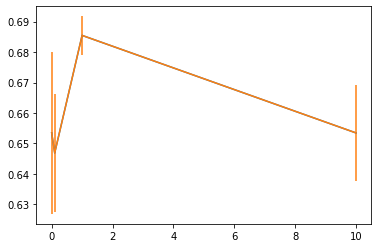

In [31]:
plt.plot(list(final_result.keys()), auc_list)
plt.errorbar(final_result.keys(), auc_list, yerr=auc_std_list, label='both limits (default)')
#plt.xscale('log')

In [33]:
auc_diff_list = [final_result[adv_rate]['auc_diff']['mean'] for adv_rate in final_result.keys()]
auc__diff_std_list = [final_result[adv_rate]['auc_diff']['std'] for adv_rate in final_result.keys()]

<ErrorbarContainer object of 3 artists>

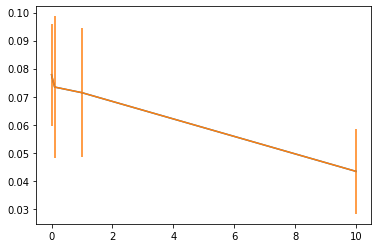

In [35]:
plt.plot(list(final_result.keys()), auc_diff_list)
plt.errorbar(final_result.keys(), auc_diff_list, yerr=auc__diff_std_list, label='both limits (default)')
#plt.xscale('log')

In [ ]:
[0.0, 0.1, 1.0, 10.0]